In [ ]:
from music21 import *

In [ ]:

def read_midi_file(file):

    print("Loading Music File:",file)

    notes=[]
    notes_to_parse = None


    midi_file = converter.parse(file)


    s2 = instrument.partitionByInstrument(midi_file)


    for part in s2.parts:


        if 'Piano' in str(part):

            notes_to_parse = part.recurse()


            for element in notes_to_parse:

                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))

                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [ ]:

import os

import numpy as np

# path='/content/drive/MyDrive/MIDI Samples/'
path = '/content/'


files_to_read=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi_file(path+i) for i in files_to_read])

Loading Music File: /content/Colors_of_the_Wind.1.mid
Loading Music File: /content/Save_The_Best_For_Last.4.mid
Loading Music File: /content/Save_The_Best_For_Last.2.mid
Loading Music File: /content/Save_The_Best_For_Last.3.mid
Loading Music File: /content/Save_The_Best_For_Last.mid
Loading Music File: /content/Colors_of_the_Wind.mid
Loading Music File: /content/Save_The_Best_For_Last.1.mid


<ipython-input-3-6a104f64eb55>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi_file(path+i) for i in files_to_read])


In [ ]:

notes_ = [element for note_ in notes_array for element in note_]


unique_notes = list(set(notes_))
print(len(unique_notes))

166


(array([140.,   8.,   7.,   5.,   2.,   1.,   1.,   0.,   1.,   1.]),
 array([  1. ,  53.4, 105.8, 158.2, 210.6, 263. , 315.4, 367.8, 420.2,
        472.6, 525. ]),
 <BarContainer object of 10 artists>)

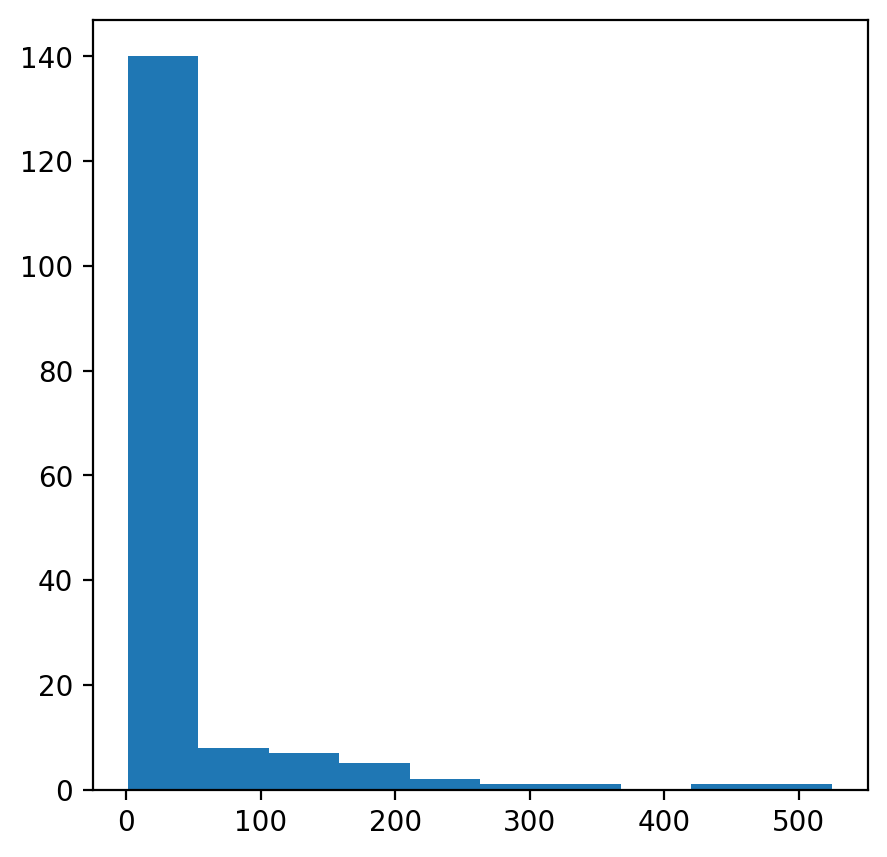

In [ ]:
from collections import Counter

freq = dict(Counter(notes_))

import matplotlib.pyplot as plt

nom=[count for _,count in freq.items()]

plt.figure(figsize=(5,5))

plt.hist(nom)

In [ ]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

27


In [ ]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)
    new_music.append(temp)

new_music = np.array(new_music)

<ipython-input-7-2fa7923ce1b3>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_music = np.array(new_music)


In [ ]:
no_of_timesteps = 128
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):

        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]

        x.append(input_)
        y.append(output)

x=np.array(x)
y=np.array(y)

In [ ]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [ ]:

x_seq=[]
for i in x:
    temp=[]
    for j in i:

        temp.append(x_note_to_int[j])
    x_seq.append(temp)

x_seq = np.array(x_seq)

In [ ]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y))
y_seq=np.array([y_note_to_int[i] for i in y])

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [ ]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()


model.add(Embedding(len(unique_x), 100, input_length=128,trainable=True))

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

#model.add(Conv1D(256,5,activation='relu'))
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          2700      
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           19264     
                                                                 
 dropout (Dropout)           (None, 128, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 64, 128)           0         
                                                        

In [ ]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=300, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

Epoch 1/300
24/24 [==============================] - ETA: 0s - loss: 3.1345
Epoch 1: val_loss improved from inf to 3.11256, saving model to best_model.h5
24/24 [==============================] - 14s 56ms/step - loss: 3.1345 - val_loss: 3.1126
Epoch 2/300
21/24 [=========================>....] - ETA: 0s - loss: 3.0619
Epoch 2: val_loss improved from 3.11256 to 3.11033, saving model to best_model.h5
24/24 [==============================] - 0s 11ms/step - loss: 3.0666 - val_loss: 3.1103
Epoch 3/300
24/24 [==============================] - ETA: 0s - loss: 3.0531
Epoch 3: val_loss improved from 3.11033 to 3.10939, saving model to best_model.h5
24/24 [==============================] - 0s 11ms/step - loss: 3.0531 - val_loss: 3.1094
Epoch 4/300
19/24 [======================>.......] - ETA: 0s - loss: 3.0476
Epoch 4: val_loss improved from 3.10939 to 3.09139, saving model to best_model.h5
24/24 [==============================] - 0s 11ms/step - loss: 3.0460 - val_loss: 3.0914
Epoch 5/300
22/24 [

In [ ]:

from keras.models import load_model
model = load_model('best_model.h5')

In [ ]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]

print(predictions)

1/1 [==============================] - 0s 19ms/step
[7, 24, 25, 6, 7, 2, 18, 18, 7, 16]


In [ ]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))
predicted_notes = [x_int_to_note[i] for i in predictions]

In [ ]:
def convert_to_midi(prediction_output):

    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:

        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:

                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)

            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)

        # pattern is a note
        else:

            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')


In [ ]:
convert_to_midi(predicted_notes)